# NucleaSeq Analysis

This notebook analyses the full-length data tabulated in the previous Tabulation and Normalization notebook, finding cleavage rates for each oligo. Various figures and sanity checks are presented.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl

In [3]:
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [4]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, Image

In [5]:
import random
import yaml
import editdistance
from collections import Counter, defaultdict
from general_sequence_tools import dna_rev_comp
from nucleaseq.OligosContainer import OligosContainer
from nucleaseq import seqtools, processing, plotting

In [6]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# Run Parameters

This section again contains the only parameters which should require user input. 

The first two cells must be exactly the same as in the previous Tabulation and Normalization notebook. 

The next, new cell requires the time point values in order as a numpy array, expected to be represented in seconds. Note this array is one shorter than `sample_names` as the control sample does not have an associated time.

In [7]:
run_label = 'Cas9_D'
tname = 'D'
read_name_by_sample_fpath = 'JA18412-100827729/Cas9_D_read_names_by_sample.txt'
exploded_oligos_fpath = 'exploded_target_d_seqs.txt'
targets_fpath = '/mnt/marble/hdd2/hawkjo/alignment_tmp/master_style/targets.yml'
pamtarg_pos = 24

In [8]:
sample_names = [
    'ControlDWE',
    'WTD0',
    'WTD12s',
    'WTD1',
    'WTD3',
    'WTD10',
    'WTD30',
    'WTD100',
    'WTD300',
    'WTD1000',
]

In [9]:
times = 60 * np.array([0, 0, 1, 3, 10, 30, 100, 300, 1000])
times[1] = 12

# Loading Data

In [10]:
targets = yaml.load(open(targets_fpath))
perfect_target = targets[tname]
print 'Target {}:'.format(tname), perfect_target

Target D: TTTAGTGATAAGTGGAATGCCATGTGG


In [11]:
oligo_container = OligosContainer(exploded_oligos_fpath, perfect_target, pamtarg_pos)

2020-04-12 06:09:37   Loaded 8,684 oligos (8,684 unique)
2020-04-12 06:09:37   Oligo lengths: Counter({116: 8684})
2020-04-12 06:09:37   43 Perfect target oligos
2020-04-12 06:09:37   8,629 Target oligos
2020-04-12 06:09:37   55 Non-target oligos
2020-04-12 06:09:38   Left/Right Primer Seqs: AACCGCCGAATAACAGAGT / AAGAACGCCTCGCACACT
2020-04-12 06:09:38   Left/Right Primer Edit Distance: 10
2020-04-12 06:09:38   Target oligo left buffers: Counter({'CAGAT': 8618, 'CAGTT': 1, 'CAGCT': 1, 'CAGTC': 1, 'CAGAA': 1, 'CAGAC': 1, 'CAGAG': 1, 'CAGTG': 1, 'CAGTA': 1, 'CAGGA': 1, 'CAGCA': 1, 'CAGGT': 1})
2020-04-12 06:09:38   Target oligo right buffers: Counter({'TGATC': 8617, 'AAGAC': 1, 'GTGAC': 1, 'AGGAC': 1, 'TCGAC': 1, 'TTGAC': 1, 'TGGAC': 1, 'CAGAC': 1, 'ATGAC': 1, 'TAGAC': 1, 'GAGAC': 1, 'ACGAC': 1, 'CTGAC': 1})
2020-04-12 06:09:38   Most common left/right buffers: CAGAT / TGATC
2020-04-12 06:09:38   31 Perfect target and most common buffer oligos
2020-04-12 06:09:38   12 Alternate buffer oli

In [12]:
cut_samples = sample_names[1:]

In [13]:
read_names_given_sample = seqtools.load_read_names_given_sample(read_name_by_sample_fpath)

2020-04-12 06:09:39   Loading read_names_given_sample from JA18412-100827729/Cas9_D_read_names_by_sample.txt


# Fitting cleavage rates

Normalizing the data and fitting cleavage rates is performed in one large function call here. Below are several figures showing intermediate steps and sanity checks.

In [14]:
import pandas as pd
from scipy.stats import pearsonr

In [15]:
res = processing.calculate_y0s_and_vks(
    run_label,
    sample_names,
    cut_samples,
    times,
    oligo_container,
    read_names_given_sample,
    bootstrap=False,
    verbose=True
)

(
    target_tab,
    norm_target_tab,
    norm_perfect_target_tab,
    med_norm_target_tab,
    med_norm_perfect_target_tab,
    med_norm_cut_target_tab,
    nontarget_tab,
    norm_nontarget_tab,
    med_norm_nontarget_tab,
    raw_norm_factors,
    ref_norm_factors,
    perfect_final_fracs,
    exp_floor,
    exponential,
    vk_y0_given_oligo_seq
) = res

Normalizing...
Calculating exp floor...
Fitting...
Done


# Second normalization

The previous notebook normalized to account for different total read counts between samples. This data is "half-normalized". 

Another source of variation between samples is differences in amplification between samples. This is due partly to normal amplification variation, and also due to the condition-dependent differences in sequence composition of each sample. To address this, we use the non-target negative control oligos in the library, which should remain essentially uncut at all time points. We use the median value of the non-target sequences (shown in thick dashed lines in the relevant figures below) as reference to normalize results a second time, resulting in comparable normalized read counts. In the figures below, "normalized" or "median-normalized" data refers to that which has had this second normalization as well.

#### Half-normalized figures

The data used for the second normalization step. The median is shown in thick dashed line.

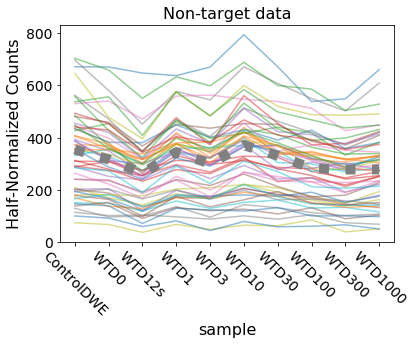

In [16]:
fig, ax = plt.subplots()
df = norm_nontarget_tab.loc[:, sample_names]
df.T.plot(legend=False, ax=ax, alpha=0.5)

ax.plot(df.median(), label='Median', color='grey', linestyle=':', linewidth=10)

ax.set_xticks(range(len(sample_names)))
ax.set_xticklabels(sample_names, rotation=-45)
ax.set_ylabel('Half-Normalized Counts')
ax.set_title('Non-target data')
print

In [17]:
df = norm_nontarget_tab.loc[:, sample_names]
np.save('{}_data_as_matrix'.format(run_label), df.as_matrix())

Correlation of half-normalized read counts of a couple time points vs. control.

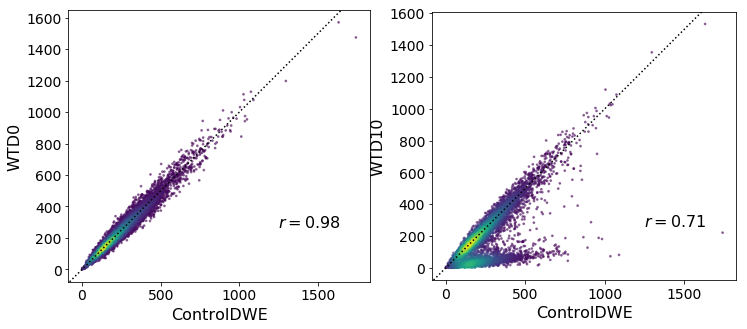

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cross_samples = [cut_samples[0], cut_samples[4]]
for ax, sample in zip(axes, cross_samples):
    x = norm_target_tab[sample_names[0]]
    y = norm_target_tab[sample]
    c = plotting.scatter_color(x, y)
    ax.scatter(x, y, c=c, s=3, alpha=0.5)
    ax.set_xlabel(sample_names[0])
    ax.set_ylabel(sample)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    r, pval = pearsonr(x, y)
    ax.text(plotting.fractional_placement(xlim, 0.8), plotting.fractional_placement(ylim, 0.2), '$r={:.2f}$'.format(r), 
            fontsize=16, ha='center')
    ax.set_aspect(1)
    ends = [max(xlim[0], ylim[0]), min(xlim[1], ylim[1])]
    ax.plot(ends, ends, 'k:')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [19]:
print 'Normalization factors:'
np.savetxt('{}_norm_factors2.txt'.format(run_label), ref_norm_factors)
combined_normalization_factors = np.array(raw_norm_factors) * ref_norm_factors
np.savetxt('{}_norm_factors_combined.txt'.format(run_label), combined_normalization_factors)
print '    '.join(['n_one', 'n_two', 'n_combined'])
for n1, n2, nc in zip(raw_norm_factors, ref_norm_factors, combined_normalization_factors):
    print ('{:.4f}   '*3).format(n1, n2, nc)

Normalization factors:
n_one    n_two    n_combined
1.0000   1.0000   1.0000   
0.6148   0.8934   0.5493   
0.8610   0.7426   0.6394   
1.5256   0.9712   1.4817   
0.6853   0.8467   0.5803   
0.7007   1.0452   0.7324   
0.7542   0.9337   0.7042   
0.8607   0.7986   0.6873   
1.6370   0.7847   1.2845   
0.7213   0.7850   0.5662   


#### Fully normalized figures

The non-target sequences after normalization. The thick dashed line should be flat by definition.

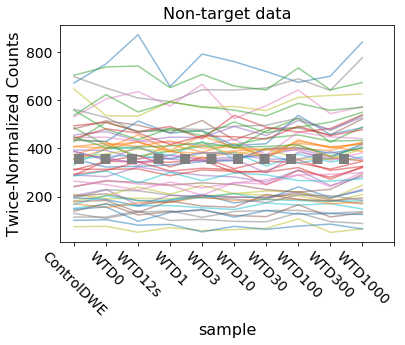

In [20]:
fig, ax = plt.subplots()
df = med_norm_nontarget_tab.loc[:, sample_names]
df.T.plot(legend=False, ax=ax, alpha=0.5)

ax.plot(df.median(), label='Median', color='grey', linestyle=':', linewidth=10)

ax.set_xticks(range(len(sample_names) + 1))
ax.set_xticklabels(sample_names, rotation=-45)
ax.set_ylabel('Twice-Normalized Counts')
ax.set_title('Non-target data')
print

Same correlation plot as previous.

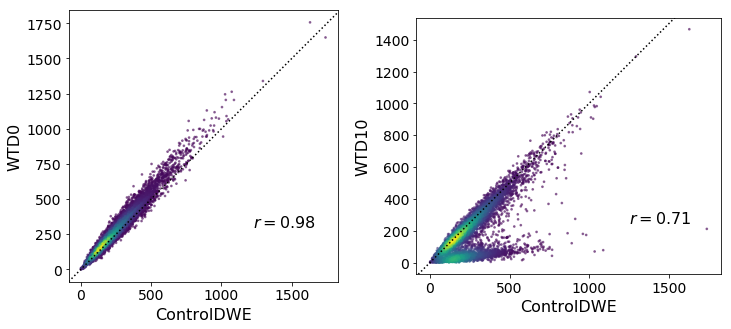

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cross_samples = [cut_samples[0], cut_samples[4]]
for ax, sample in zip(axes, cross_samples):
    x = med_norm_target_tab[sample_names[0]]
    y = med_norm_target_tab[sample]
    c = plotting.scatter_color(x, y)
    ax.scatter(x, y, c=c, s=3, alpha=0.5)
    ax.set_xlabel(sample_names[0])
    ax.set_ylabel(sample)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    r, pval = pearsonr(x, y)
    ax.text(plotting.fractional_placement(xlim, 0.8), plotting.fractional_placement(ylim, 0.2), '$r={:.2f}$'.format(r), 
            fontsize=16, ha='center')
    ax.set_aspect(1)
    ends = [max(xlim[0], ylim[0]), min(xlim[1], ylim[1])]
    ax.plot(ends, ends, 'k:')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Normalized read counts for fully matched, or "perfect", oligos. Many copies of the perfect target sequence are included in the library with different barcodes for redundancy. Samples are evenly spaced on the x-axis, independent of time. 

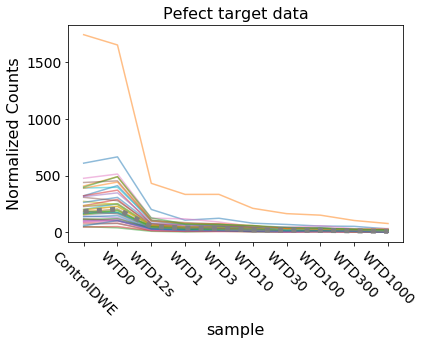

In [22]:
fig, ax = plt.subplots()
df = med_norm_perfect_target_tab.loc[:, sample_names]
df.T.plot(legend=False, ax=ax, alpha=0.5)

ax.plot(df.median(), label='Median', color='grey', linestyle=':', linewidth=5)

ax.set_xticks(range(len(sample_names)))
ax.set_xticklabels(sample_names, rotation=-45)
ax.set_ylabel('Normalized Counts')
ax.set_title('Pefect target data')
print

Same as previous, but with the zero time point set to one.

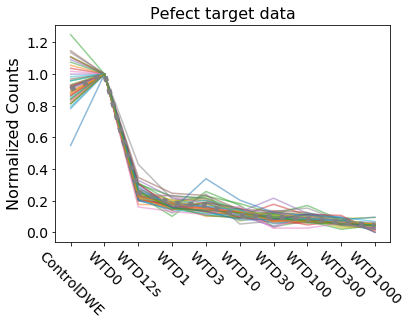

In [23]:
fig, ax = plt.subplots()
df = med_norm_perfect_target_tab.loc[:, sample_names]
for index, row in df.iterrows():
    y = np.array(row)
    y /= y[1]
    ax.plot(y, alpha=0.5)
#df.T.plot(legend=False, ax=ax, alpha=0.5)

y = np.array(df.median())
y /= y[1]
ax.plot(y, label='Median', color='grey', linestyle=':', linewidth=5)

ax.set_xticks(range(len(sample_names)))
ax.set_xticklabels(sample_names, rotation=-45)
ax.set_ylabel('Normalized Counts')
ax.set_title('Pefect target data')
print

The distribution of the last time point for perfect targets. The median value is used as the floor of exponential fits.

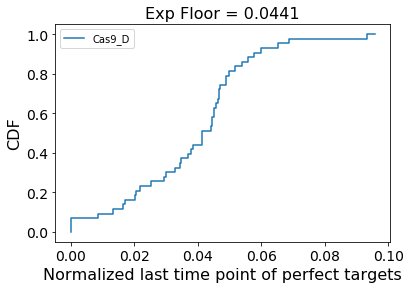

In [24]:
fig, ax = plt.subplots()
plotting.plot_cdf(ax, perfect_final_fracs, label=run_label)
ax.legend()

ax.set_xlabel('Normalized last time point of perfect targets')
ax.set_ylabel('CDF')
ax.set_title('Exp Floor = {:.4f}'.format(exp_floor))
print

## Example fits

In [25]:
bases = seqtools.bases

In [26]:
perfect_oligo_seqs = [oligo.sequence for oligo in oligo_container.perfect_target_oligos]

In [27]:
thalf_y0_given_oligo_seq = {oligo_seq: (np.log(2)/vk, y0) 
                            for oligo_seq, (vk, y0) in vk_y0_given_oligo_seq.items()}
vk_given_target = {oligo_container.oligo_given_seq[oligo_seq]._target: vk
                   for oligo_seq, (vk, y0) in vk_y0_given_oligo_seq.items()}

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


In [28]:
idx_given_single_mismatch_target = {
    perfect_target[:i] + base + perfect_target[i+1:]: i for i in range(len(perfect_target))
    for base in bases.replace(perfect_target[i], '')
}
single_mismatch_seqs = {oligo.sequence: oligo.convert_target_pos_to_pamtarg_coord(idx_given_single_mismatch_target[oligo._target])
                        for oligo in oligo_container.target_oligos if oligo._target in idx_given_single_mismatch_target.keys()}

In [29]:
seq_read_counts_given_oligo_seq = {}
for i, oligo_seq in enumerate(med_norm_cut_target_tab.index):
    seq_read_counts = list(med_norm_cut_target_tab.iloc[i])
    seq_read_counts_given_oligo_seq[oligo_seq] = seq_read_counts

In [30]:
def plot_seqs_data_and_fits(ax, seqs, labels):
    """Plots the data and fits for given list of seqs"""
    for seq, label in zip(seqs, labels):
        seq_read_counts = seq_read_counts_given_oligo_seq[seq]
        x = [0.1] + list(times)[1:]
        ax.plot(x, seq_read_counts, 's', label=label + ' data')

        thalf, y0 = thalf_y0_given_oligo_seq[seq]
        x = np.logspace(np.log10(x[0]), np.log10(x[-1]), 10000)
        y = [exponential(xx, y0, np.log(2)/thalf) for xx in x]
        ax.plot(x, y, label=label + ' fit')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized Reads')

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ylim = (0, ylim[1])
    ax.text(plotting.fractional_placement(xlim, 0.3),
            plotting.fractional_placement(ylim, 0.5),
            '$t_{1/2} = ' + '{:.1f}$'.format(thalf),
            fontsize=16, ha='center')
    ax.set_ylim(ylim)
    ax.legend(fontsize=12)

Two randomly selected example fits each from perfect matching sequence (fast-cleaving), medium-cleaving, and slow-cleaving sequences. More examples can be viewed by rerunning a given cell. Definition of medium and slow half-lives can be set in the next cell.

In [31]:
medium_lb = 100
medium_ub = 1000
slow_lb = 1000
slow_ub = 10000

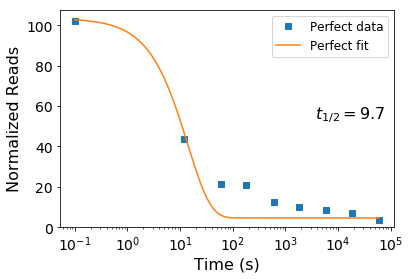

In [32]:
seq = random.choice(perfect_oligo_seqs)
fig, ax = plt.subplots()
plot_seqs_data_and_fits(ax, [seq], ['Perfect'])
ax.set_xscale('log')

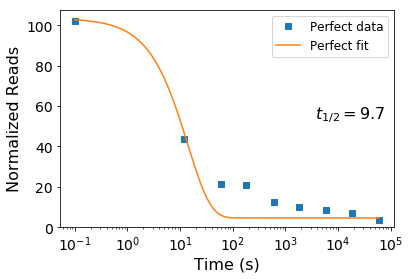

In [33]:
seq = random.choice(perfect_oligo_seqs)
fig, ax = plt.subplots()
plot_seqs_data_and_fits(ax, [seq], ['Perfect'])
ax.set_xscale('log')

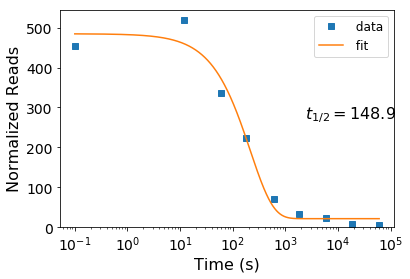

In [34]:
oligo_seqs = seq_read_counts_given_oligo_seq.keys()
for _ in range(100):
    seq = random.choice(oligo_seqs)
    thalf, y0 = thalf_y0_given_oligo_seq[seq]
    if medium_lb < thalf < medium_ub:
        break
fig, ax = plt.subplots()
plot_seqs_data_and_fits(ax, [seq], [''])
ax.set_xscale('log')

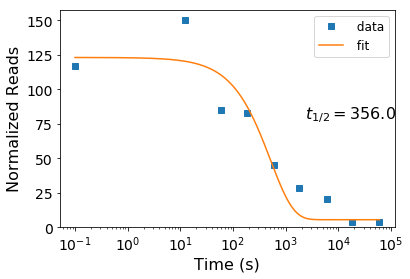

In [35]:
oligo_seqs = seq_read_counts_given_oligo_seq.keys()
for _ in range(100):
    seq = random.choice(oligo_seqs)
    thalf, y0 = thalf_y0_given_oligo_seq[seq]
    if medium_lb < thalf < medium_ub:
        break
fig, ax = plt.subplots()
plot_seqs_data_and_fits(ax, [seq], [''])
ax.set_xscale('log')

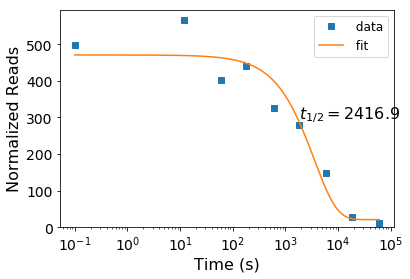

In [36]:
oligo_seqs = seq_read_counts_given_oligo_seq.keys()
for _ in range(100):
    seq = random.choice(oligo_seqs)
    thalf, y0 = thalf_y0_given_oligo_seq[seq]
    if slow_lb < thalf < slow_ub:
        break
fig, ax = plt.subplots()
plot_seqs_data_and_fits(ax, [seq], [''])
ax.set_xscale('log')

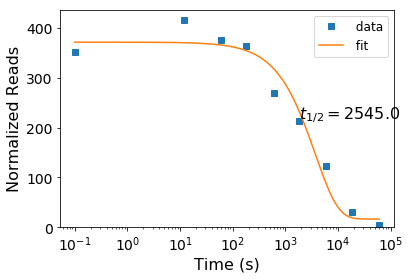

In [37]:
oligo_seqs = seq_read_counts_given_oligo_seq.keys()
for _ in range(100):
    seq = random.choice(oligo_seqs)
    thalf, y0 = thalf_y0_given_oligo_seq[seq]
    if slow_lb < thalf < slow_ub:
        break
fig, ax = plt.subplots()
plot_seqs_data_and_fits(ax, [seq], [''])
ax.set_xscale('log')

TTTAGTGATAAGTGGAATGCCATGTAG


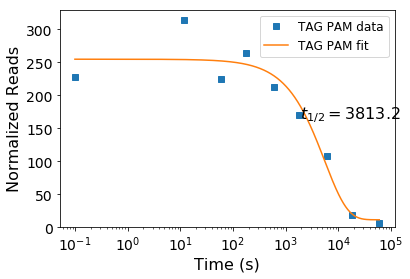

In [38]:
tag_pam_target = perfect_target[:-2] + 'AG'
for oligo in oligo_container.oligos:
    if oligo._target == tag_pam_target:
        seq = oligo.sequence
        break
else:
    print 'Not found'
print tag_pam_target

fig, ax = plt.subplots()
plot_seqs_data_and_fits(ax, [seq], ['TAG PAM'])
ax.set_xscale('log')

# Cleavage Rate Summary Figures

In [39]:
oligo_seq_given_target = {oligo._target: oligo.sequence for oligo in oligo_container.target_oligos}

### Single mismatch

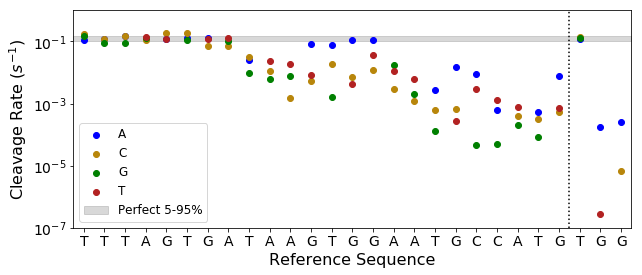

In [40]:
fig, ax = plt.subplots(figsize=(10, 4))
color_given_base = {'A': 'blue', 'C': 'darkgoldenrod', 'G': 'green', 'T': 'firebrick'}
idxs = np.arange(len(perfect_target))
for i, base in enumerate(bases):
    kkms = []
    for base_idx in idxs:
        if perfect_target[base_idx] == base:
            kkms.append(None)
            continue
        seq = perfect_target[:base_idx] + base + perfect_target[base_idx + 1:]
        if seq not in vk_given_target:
            kkms.append(None)
            continue
        kkms.append(vk_given_target[seq])
    ax.scatter(idxs, kkms, c=color_given_base[base], label=base)
ax.set_yscale('log')
ax.set_xticks(idxs)

perfect_kkms = []
for oligo_seq in perfect_oligo_seqs:
    thalf, y0 = thalf_y0_given_oligo_seq[oligo_seq]
    perfect_kkms.append(np.log(2)/thalf)
ax.set_xticklabels(perfect_target)
xlim = (-0.5, 26.5)
ax.fill_between(xlim, np.percentile(perfect_kkms, 5), np.percentile(perfect_kkms, 95), 
                color='grey', alpha=0.3, zorder=-1, label='Perfect 5-95%')
ylim = (1e-7, 1)
ax.plot([23.5]*2, ylim, 'k:')
ax.set_ylim(ylim)
ax.set_xlim(xlim)

ax.set_xlabel('Reference Sequence')
ax.set_ylabel('Cleavage Rate ($s^{-1}$)')
ax.legend(fontsize=12)
print

### Double mismatch

In this figure and those below, single mismatch, deletion, or insertion data is shown along the diagonal.

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


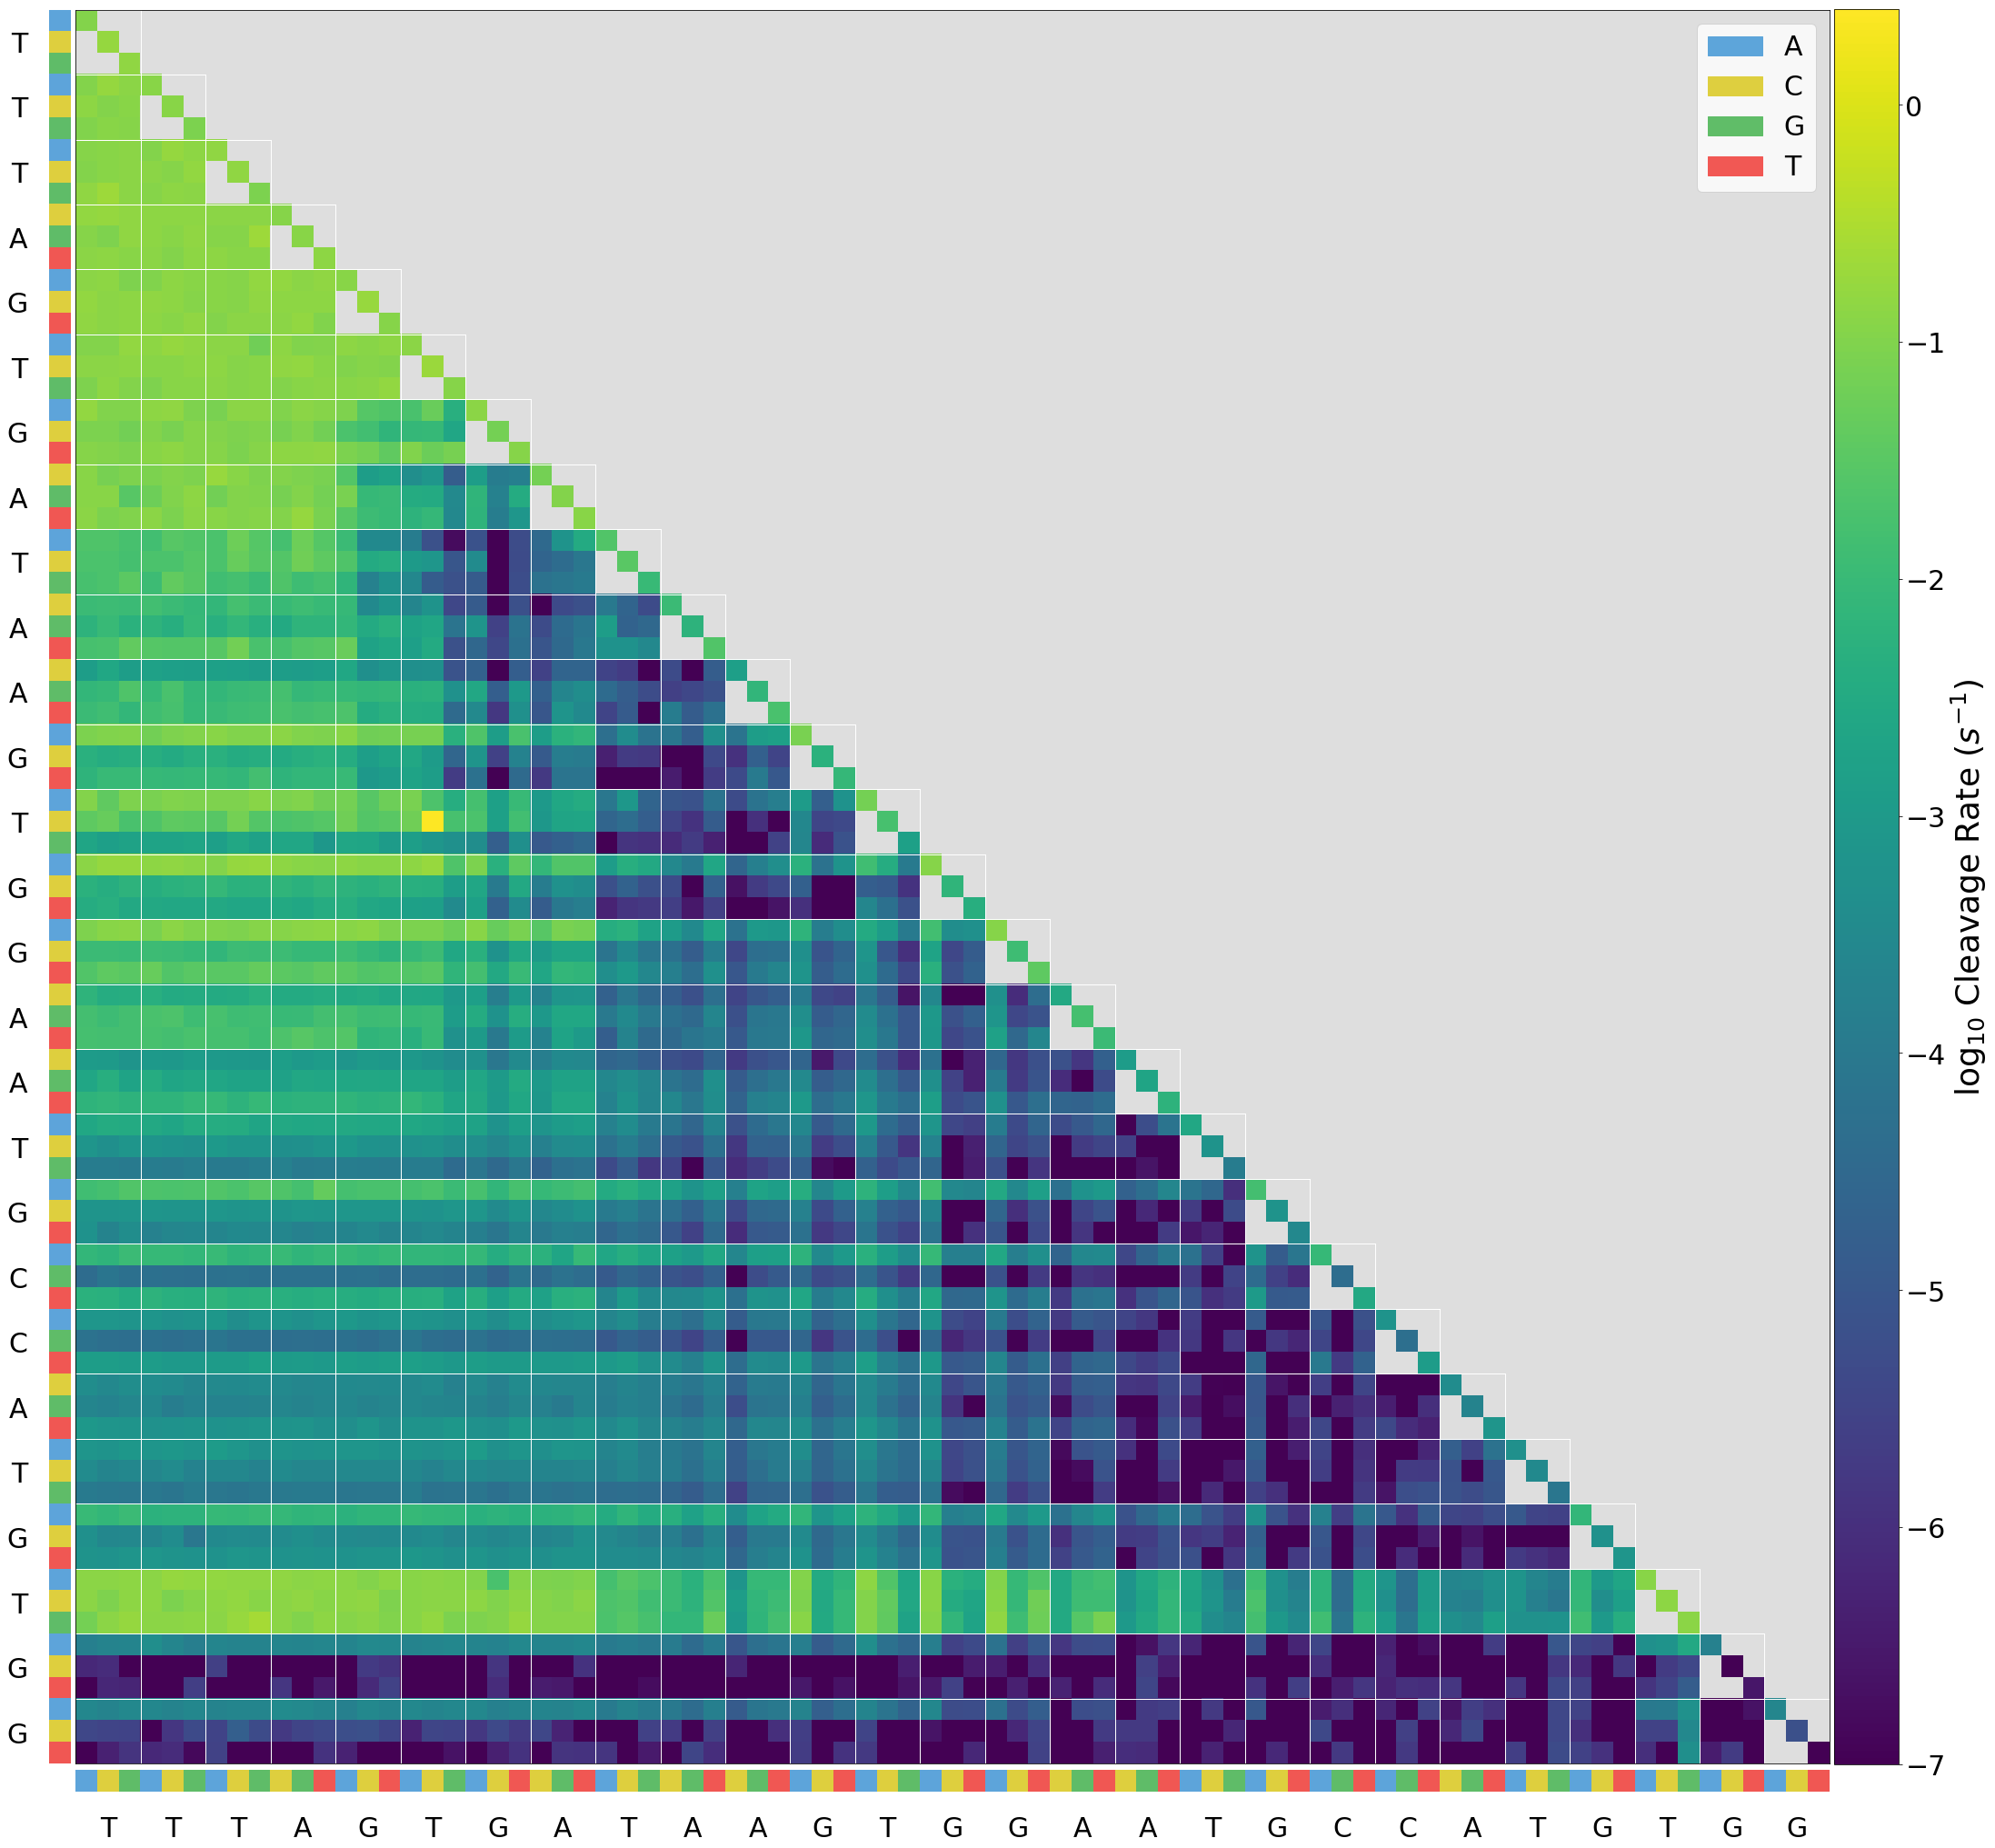

In [41]:
M = np.log10(seqtools.double_mismatch_matrix(vk_given_target, perfect_target))
M[M < -7] = -7
plotting.plot_2d_mismatches(
    perfect_target, 
    perfect_target, 
    M)

### Double deletion

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


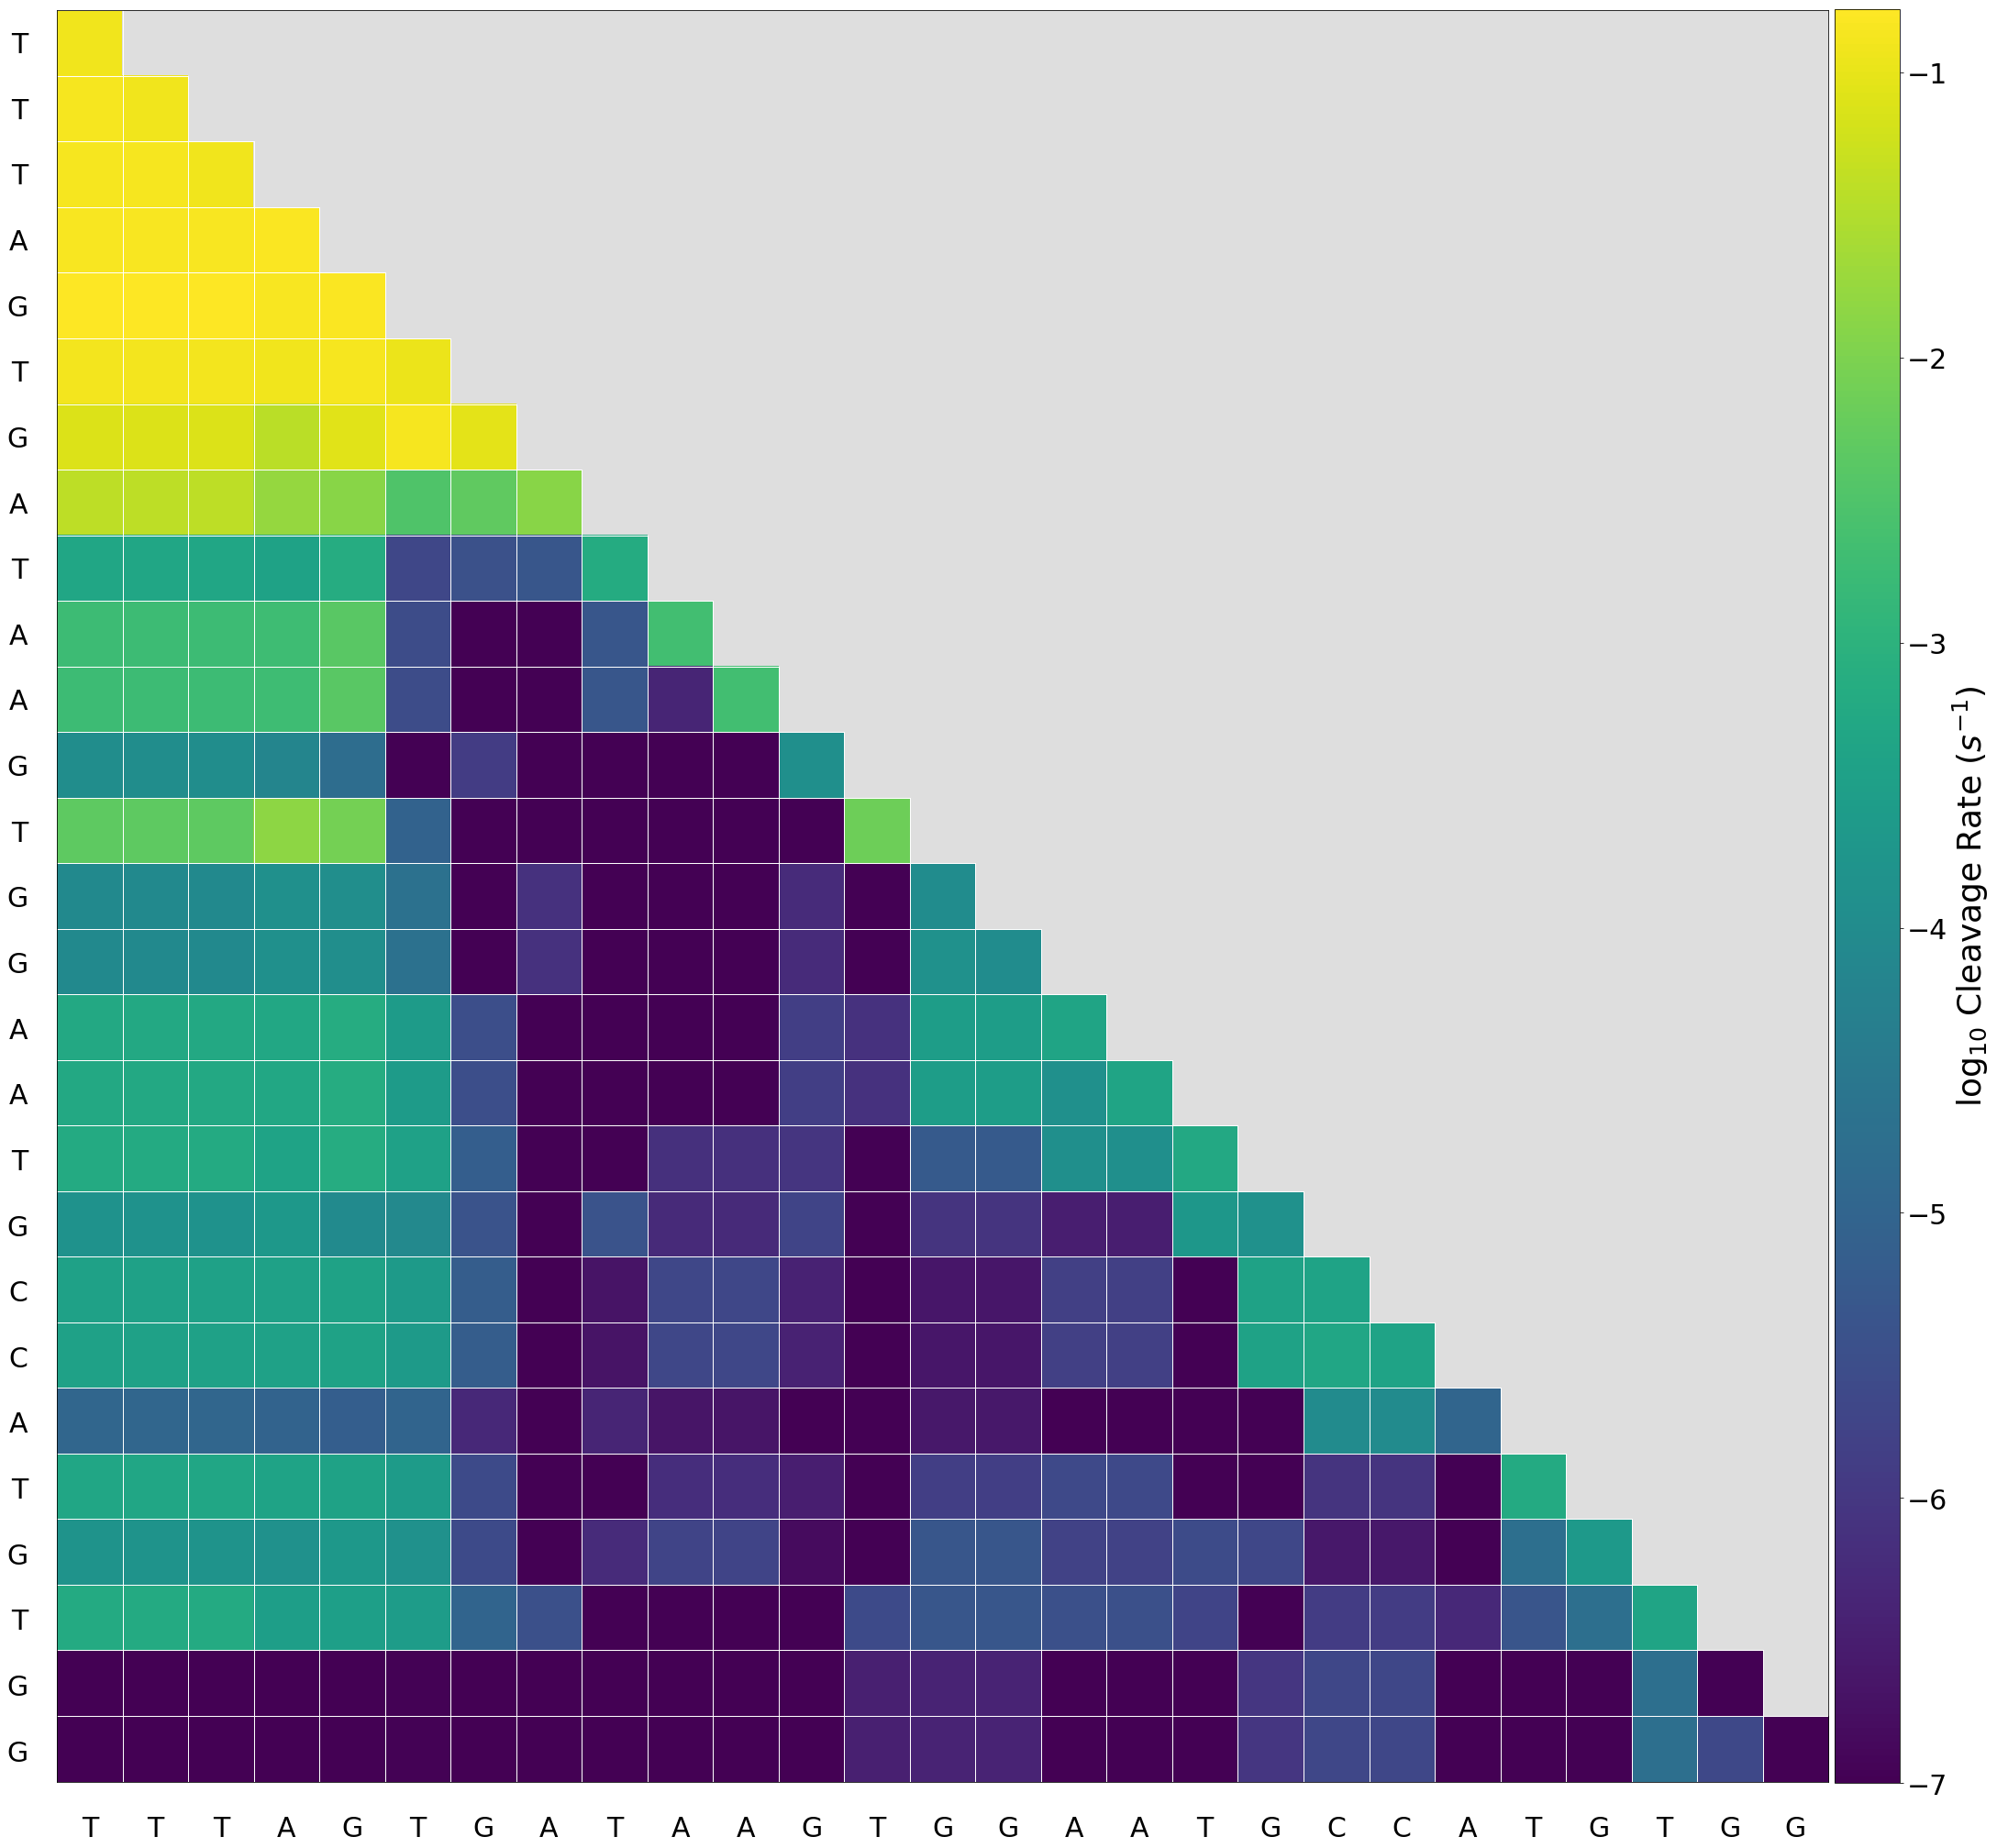

In [42]:
M = np.log10(seqtools.double_deletion_matrix(vk_given_target, perfect_target))
M[M < -7] = -7
plotting.plot_2d_deletions(
    perfect_target, 
    perfect_target, 
    M)

### Double insertion

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


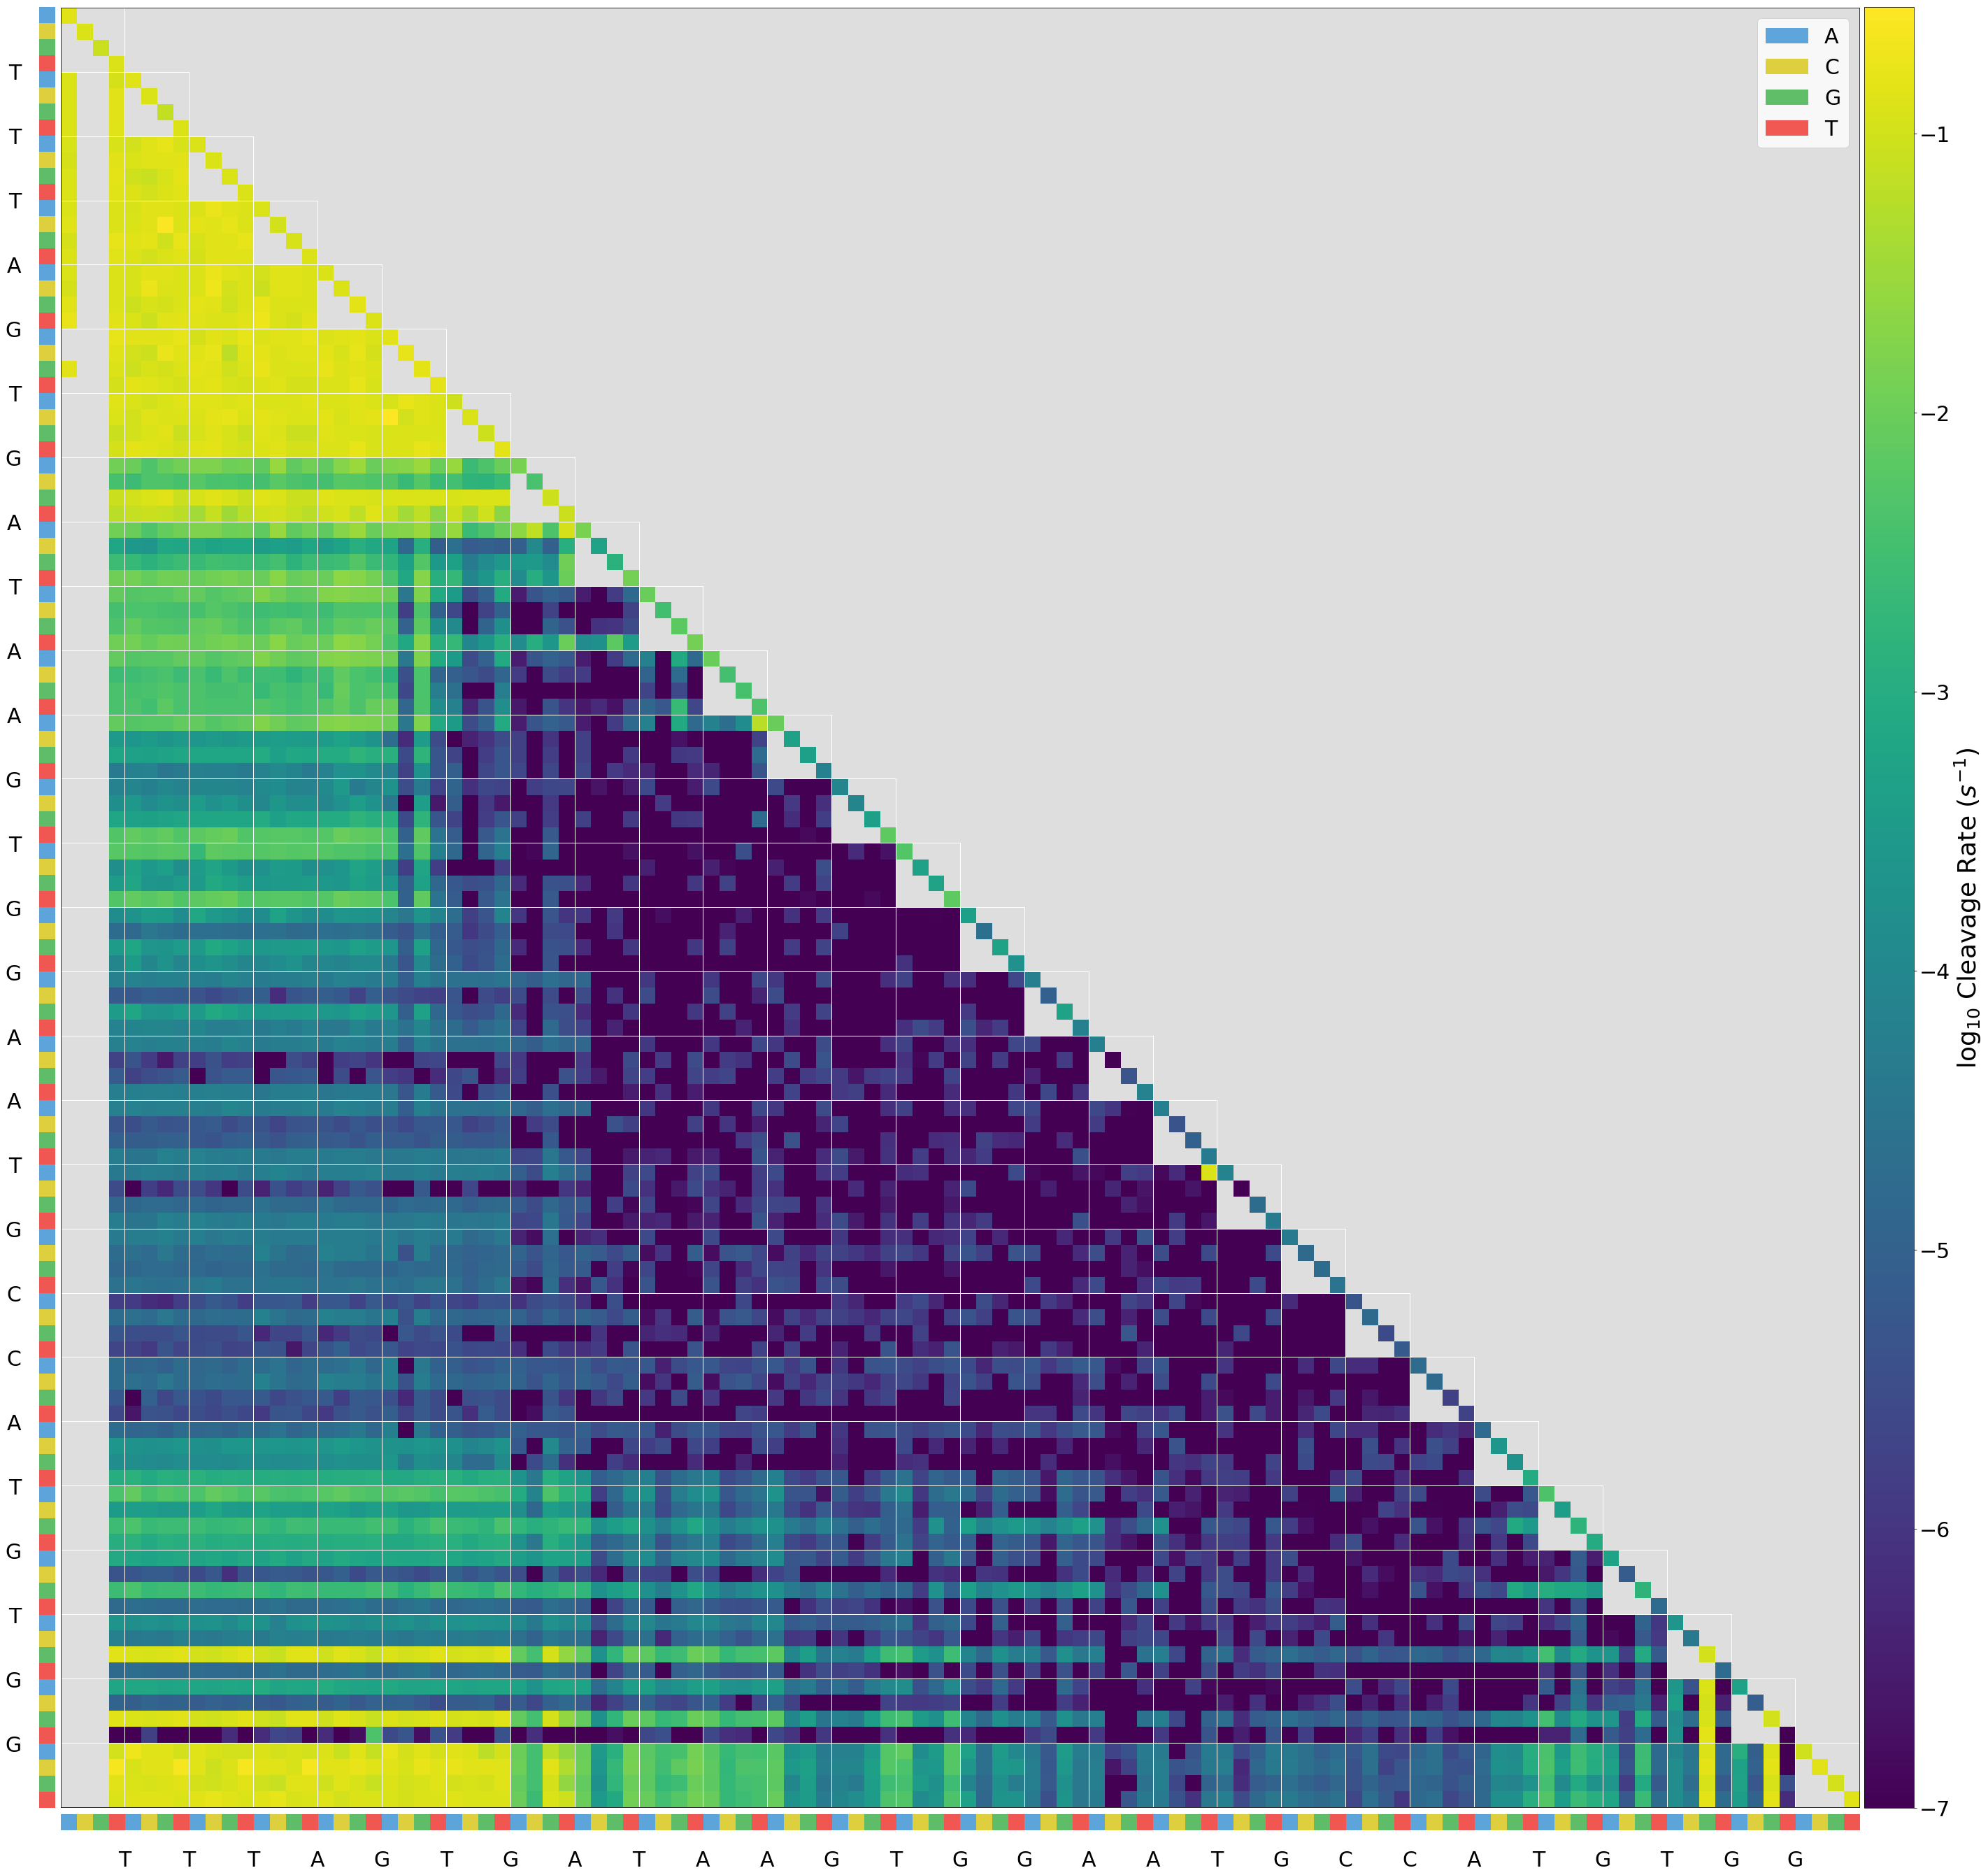

In [43]:
M = np.log10(seqtools.double_insertion_matrix(vk_given_target, perfect_target))
M[M < -7] = -7
plotting.plot_2d_insertions(
    perfect_target, 
    perfect_target, 
    M)

### Complement stretches

Each point in this graph represents a sequence where the sub-sequence from Start to Stop position has been changed to its forward complement.

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


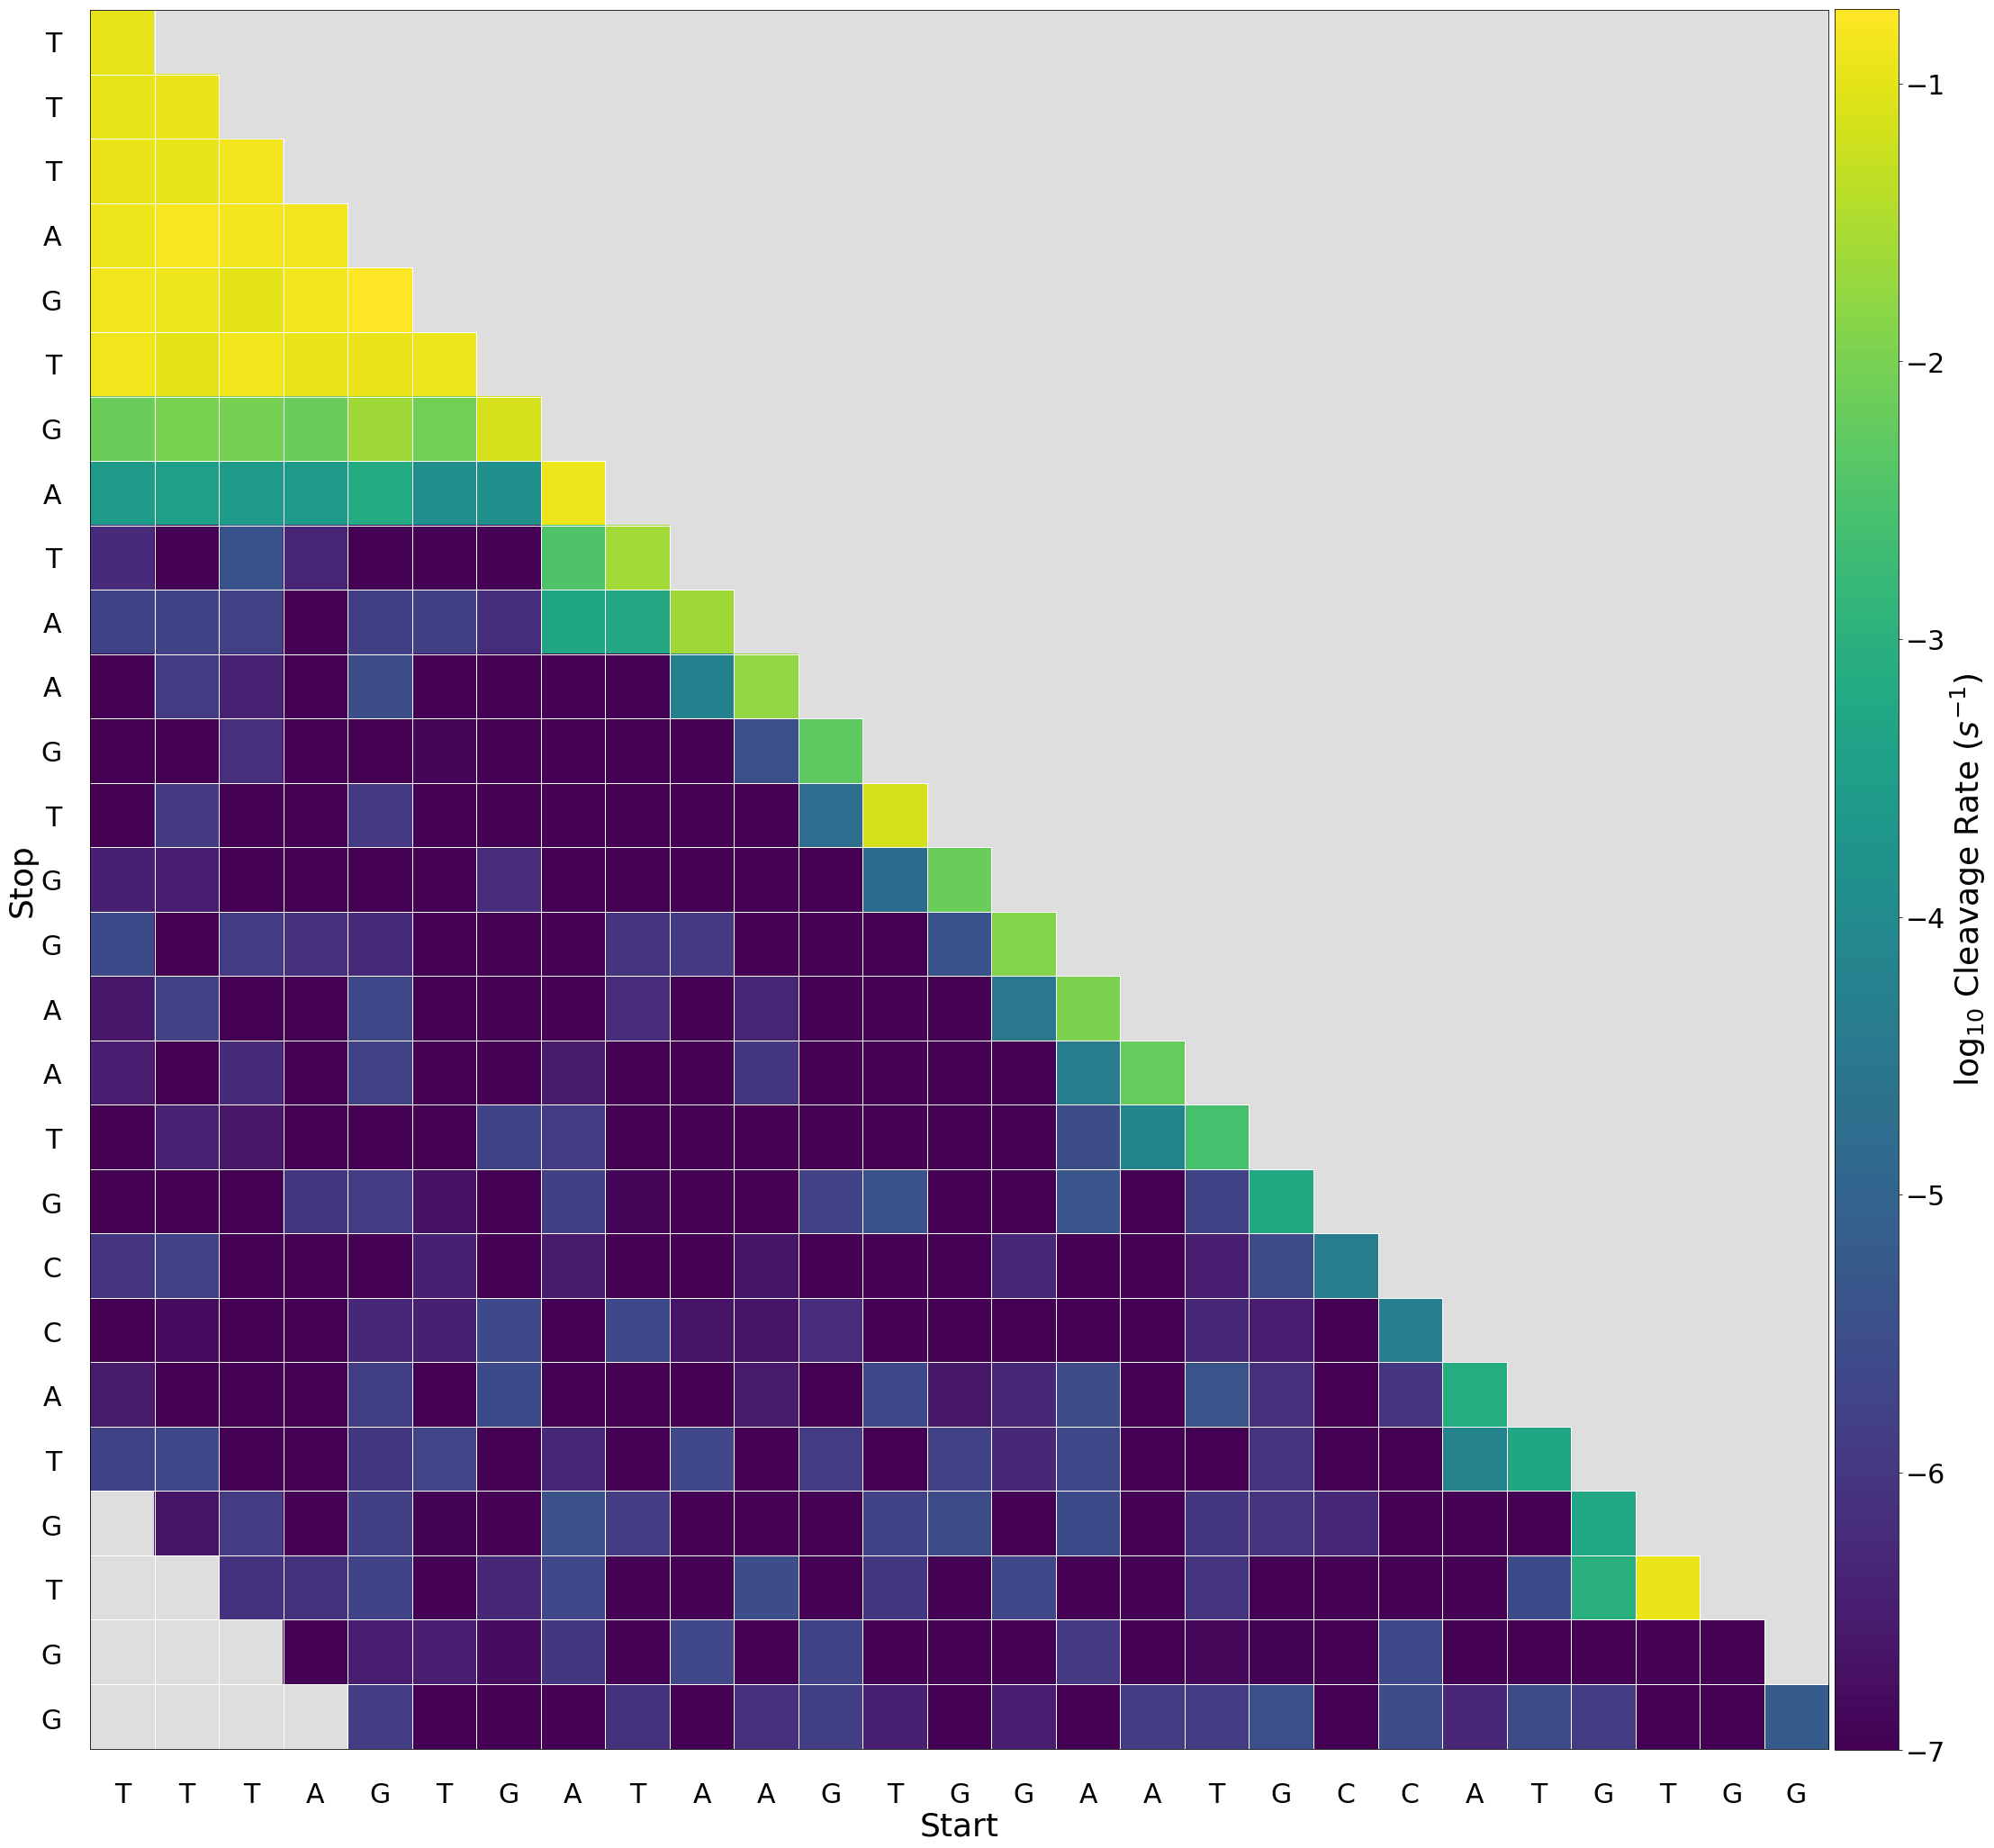

In [44]:
M = np.log10(seqtools.complement_stretches_matrix(vk_given_target, perfect_target))
M[M < -7] = -7
plotting.plot_complement_stretches(
    perfect_target, 
    perfect_target, 
    M)

# Output Sequence Read Counts

In [45]:
seq_read_counts_given_oligo_seq
seq_read_counts_fpath = '{}_normed_read_counts.txt'.format(run_label)
with open(seq_read_counts_fpath, 'w') as out:
    for oligo_seq, src in sorted(seq_read_counts_given_oligo_seq.items()):
        out.write('{}\t{}\n'.format(oligo_seq, '\t'.join(map(str, src))))

# Bootstrapping

In [46]:
num_bootstraps = 100
bootstrap_vk_y0s = []
for _ in range(num_bootstraps):
    sys.stdout.write('.')
    sys.stdout.flush()
    
    res = processing.calculate_y0s_and_vks(
        run_label,
        sample_names,
        cut_samples,
        times,
        oligo_container,
        read_names_given_sample,
        bootstrap=True,
        verbose=False
    )

    _, _, _, _, _, _, _, _, _, _, _, _, _, _, bootstrap_vk_y0_given_oligo_seq = res
    
    bootstrap_vk_y0s.append(bootstrap_vk_y0_given_oligo_seq)

....................................................................................................

In [47]:
cut_fpath = '{}_cleavage_rate_and_y0.txt'.format(run_label)
log_vk_y0_err_given_oligo_seq = {}
conf_intvl_90_given_oligo_seq = {}
with open(cut_fpath, 'w') as out:
    oligo = oligo_container.oligo_given_seq[vk_y0_given_oligo_seq.keys()[0]]
    out.write('\t'.join(['\t'.join(oligo.pieces_names), 'cleavage_rate', 'log10_cleavage_rate_err', 'cleavage_rate_5th_pctl', 'cleavage_rate_95th_pctl', 'y0', 'y0_err']) + '\n')
    for seq, (vk, y0) in sorted(vk_y0_given_oligo_seq.items()):
        other_vks = [d_vk_y0[seq][0] for d_vk_y0 in bootstrap_vk_y0s]
        other_y0s = [d_vk_y0[seq][1] for d_vk_y0 in bootstrap_vk_y0s]
        log_vk_err = np.std([np.log10(vk) for vk in other_vks])
        pctl5 = np.percentile(other_vks, 5)
        pctl_95 = np.percentile(other_vks, 95)
        y0_err = np.std(other_y0s)
        log_vk_y0_err_given_oligo_seq[seq] = (log_vk_err, y0_err)
        conf_intvl_90_given_oligo_seq[seq] = (pctl5, pctl_95)
        oligo = oligo_container.oligo_given_seq[seq]
        out.write('\t'.join(map(str, ['\t'.join(oligo.pieces), vk, log_vk_err, pctl5, pctl_95, y0, y0_err])) + '\n')

# Single-mismatch with Error bars

Error bars represent 90% confidence intervals.

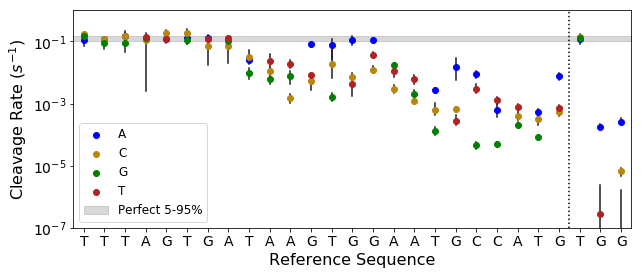

In [48]:
fig, ax = plt.subplots(figsize=(10, 4))
color_given_base = {'A': 'blue', 'C': 'darkgoldenrod', 'G': 'green', 'T': 'firebrick'}
idxs = np.arange(len(perfect_target))
w=0.1
for i, base in enumerate(bases):
    kkms = []
    kkm_errs = []
    for pos_idx in idxs:
        if perfect_target[pos_idx] == base:
            kkms.append(None)
            kkm_errs.append(None)
            continue
        seq = perfect_target[:pos_idx] + base + perfect_target[pos_idx + 1:]
        if seq not in vk_given_target:
            kkms.append(None)
            kkm_errs.append(None)
            continue
        kkms.append(vk_given_target[seq])
        oligo_seq = oligo_seq_given_target[seq]
        ax.plot([pos_idx]*2, conf_intvl_90_given_oligo_seq[oligo_seq], color=0.1*np.ones((3,)), zorder=-1)
    x = [idx for idx, kkm, kkm_err in zip(idxs, kkms, kkm_errs) if kkm_err is not None]
    y = [kkm for idx, kkm, kkm_err in zip(idxs, kkms, kkm_errs) if kkm_err is not None]
    yerr = [kkm_err for idx, kkm, kkm_err in zip(idxs, kkms, kkm_errs) if kkm_err is not None]
    ax.scatter(idxs, kkms, c=color_given_base[base], label=base)
ax.set_xticks(idxs)
ax.set_yscale('log')
perfect_kkms = []
for oligo_seq in perfect_oligo_seqs:
    thalf, y0 = thalf_y0_given_oligo_seq[oligo_seq]
    perfect_kkms.append(np.log(2)/thalf)
ax.set_xticklabels(perfect_target)
xlim = (-0.5, 26.5)
ax.fill_between(xlim, np.percentile(perfect_kkms, 5), np.percentile(perfect_kkms, 95), 
                color='grey', alpha=0.3, zorder=-1, label='Perfect 5-95%')
ylim = (1e-7, 1)
ax.plot([23.5]*2, ylim, 'k:')
ax.set_ylim(ylim)
ax.set_xlim(xlim)

ax.set_xlabel('Reference Sequence')
ax.set_ylabel('Cleavage Rate ($s^{-1}$)')
ax.legend(fontsize=12)
print